## Exploratory Data Analysis

In [2]:
pip install wordnet

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install spacy

     --------------------------------------- 12.1/12.1 MB 17.2 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 18.8 MB/s eta 0:00:00
     ------------------------------------- 381.9/381.9 kB 11.6 MB/s eta 0:00:00
     ------------------------------------- 181.6/181.6 kB 11.4 MB/s eta 0:00:00
     ---------------------------------------- 122.2/122.2 kB ? eta 0:00:00
     ---------------------------------------- 45.9/45.9 kB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 50.1/50.1 kB 2.7 MB/s eta 0:00:00
     ------------------------------------- 481.9/481.9 kB 31.4 MB/s eta 0:00:00
     ---------------------------------------- 1.9/1.9 MB 39.9 MB/s eta 0:00:00
     ---------------------------------------- 6.6/6.6 MB 24.8 MB/s eta 0:00:00
     ---------------------------------------- 45.0/45.0 kB ? eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
intel-tensorflow 2.8.0 requires libclang>=9.0.1, which is not installed.
intel-tensorflow 2.8.0 requires tensorflow-io-gcs-filesystem>=0.23.1, which is not installed.
intel-tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
wordnet 0.0.1b2 requires colorama==0.3.9, but you have colorama 0.4.6 which is incompatible.


In [154]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [7]:
!python -m spacy download en_core_web_sm

     --------------------------------------- 12.8/12.8 MB 12.6 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [9]:
pip install folium

     -------------------------------------- 100.3/100.3 kB 1.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install geopy

     -------------------------------------- 125.4/125.4 kB 2.5 MB/s eta 0:00:00
     -------------------------------------- 40.3/40.3 kB 970.5 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [127]:
pip install WordCloud

     -------------------------------------- 152.1/152.1 kB 3.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import spacy
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# from google.colab import drive
from sklearn.feature_extraction.text import CountVectorizer
import folium
from geopy.geocoders import Nominatim
from IPython.display import display
from wordcloud import WordCloud

In [155]:
import networkx as nx
import plotly.express as px

In [33]:
# Download NLTK resources
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vanam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vanam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vanam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [35]:
df_wc = pd.read_csv('dataset/final_cleaned_data/west_coast_cleaned_data.csv')
df_ec = pd.read_csv('dataset/final_cleaned_data/east_coast_cleaned_data.csv')
df_mw = pd.read_csv('dataset/final_cleaned_data/mid_west_cleaned_data.csv')

In [36]:
df = pd.concat([df_wc, df_ec, df_mw], ignore_index=True)
df.describe()

,Unnamed: 0
count,45.000000
mean,7.000000
std,4.369314
min,0.000000
25%,3.000000
50%,7.000000
75%,11.000000
max,14.000000


## DataFrame Structure

The DataFrame (`df`) contains the following columns:

1. **'title':**
   - Represents the title of the news article.

2. **'article':**
   - Contains the body or content of the news article.

3. **'news_source':**
   - Indicates the name of the publishing agency or news source.

4. **'region':**
   - Specifies the region to which the news article belongs ('east-coast', 'mid-west', 'west-coast').

5. **'article_cleaned':**
   - Contains the preprocessed and cleaned version of the article text.

6. **'converted_date':**
   - Represents the date of the article, potentially in a converted format.

7. **'year':**
   - Represents the year of the article.

8. **'entities':**
   - Contains information about entities extracted from the article. This could include named entities such as people, organizations, locations, etc.

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       45 non-null     int64 
 1   title            45 non-null     object
 2   article          45 non-null     object
 3   news_source      45 non-null     object
 4   region           45 non-null     object
 5   article_cleaned  45 non-null     object
 6   converted_date   45 non-null     object
dtypes: int64(1), object(6)
memory usage: 2.6+ KB


In [38]:
df.head(1)

,Unnamed: 0,title,article,news_source,region,article_cleaned,converted_date
0,0,Commentary: Driving an EV does not make you p...,['When I started driving an electric vehicle i...,latimes,west-coast,started driving electric vehicle 2018 became p...,09-17-2022


In [39]:
df['Unnamed: 0']

0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15     0
16     1
17     2
18     3
19     4
20     5
21     6
22     7
23     8
24     9
25    10
26    11
27    12
28    13
29    14
30     0
31     1
32     2
33     3
34     4
35     5
36     6
37     7
38     8
39     9
40    10
41    11
42    12
43    13
44    14
Name: Unnamed: 0, dtype: int64

In [40]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [41]:
df.columns

Index(['title', 'article', 'news_source', 'region', 'article_cleaned',
       'converted_date'],
      dtype='object')

In [42]:
df.index

RangeIndex(start=0, stop=45, step=1)

In [43]:
df = df.rename_axis('article_no')

In [44]:
df.columns

Index(['title', 'article', 'news_source', 'region', 'article_cleaned',
       'converted_date'],
      dtype='object')

In [45]:
df.head(1)

,title,article,news_source,region,article_cleaned,converted_date
article_no,,,,,,
0,Commentary: Driving an EV does not make you p...,['When I started driving an electric vehicle i...,latimes,west-coast,started driving electric vehicle 2018 became p...,09-17-2022


In [46]:
df.index

RangeIndex(start=0, stop=45, step=1, name='article_no')

### Wordclouds for each Region

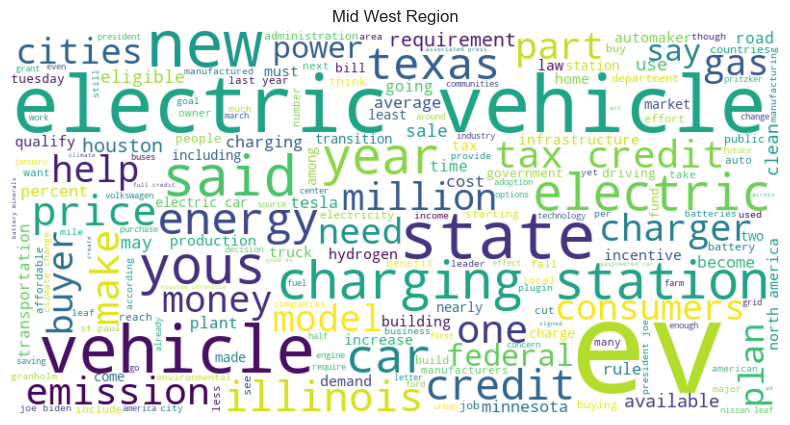

In [129]:
# word cloud for mid west

# Combine all the preprocessed text into a single string
combined_text = ' '.join(df_mw['article_cleaned'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

# Display the Word Cloud
plt.figure(figsize=(10, 5))
plt.title("Mid West Region")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

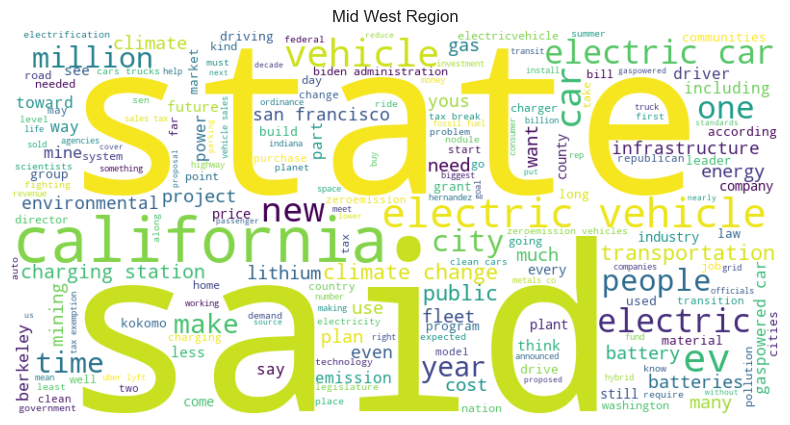

In [130]:
# word cloud for west coast

# Combine all the preprocessed text into a single string
combined_text = ' '.join(df_wc['article_cleaned'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

# Display the Word Cloud
plt.figure(figsize=(10, 5))
plt.title("Mid West Region")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

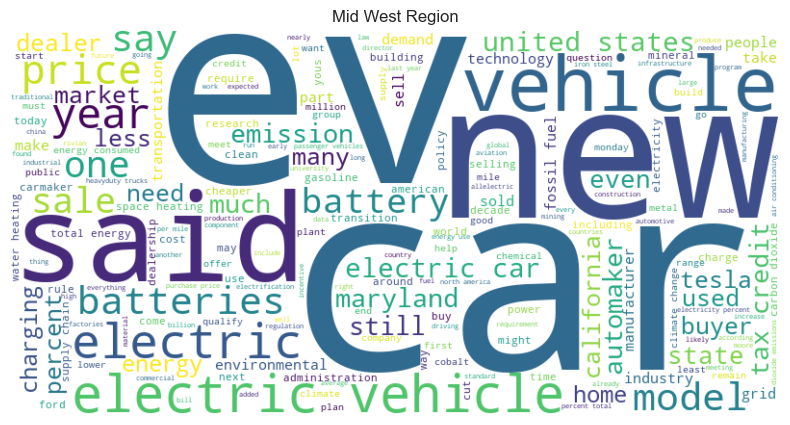

In [131]:
# word cloud for east coast

# Combine all the preprocessed text into a single string
combined_text = ' '.join(df_ec['article_cleaned'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

# Display the Word Cloud
plt.figure(figsize=(10, 5))
plt.title("Mid West Region")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [47]:
df['year'] = df['converted_date'].str.split('-').str[-1].astype(int)

In [48]:
print("Number of words per sample: " ,np.mean(df['article_cleaned'].apply(lambda x: len(x.split()))))

Number of words per sample:  621.7333333333333


The code(plot_sample_length_distribution function) generates and displays a KDE plot showing the distribution of the lengths of samples in the 'article' column 
of the DataFrame df. The x-axis represents the length of a sample, the y-axis represents the density, and the plot 
provides insights into how the lengths of the samples are distributed.

In [49]:
def plot_sample_length_distribution(sample_texts):
    """
        samples_texts
    """
    plt.figure(figsize=(10, 6))
    sns.kdeplot([len(s) for s in sample_texts], fill=True, color='skyblue')
    plt.xlabel('Length of a sample')
    plt.ylabel('Density')
    plt.title('Kernel Density Estimate of Sample Length Distribution')
    plt.show()

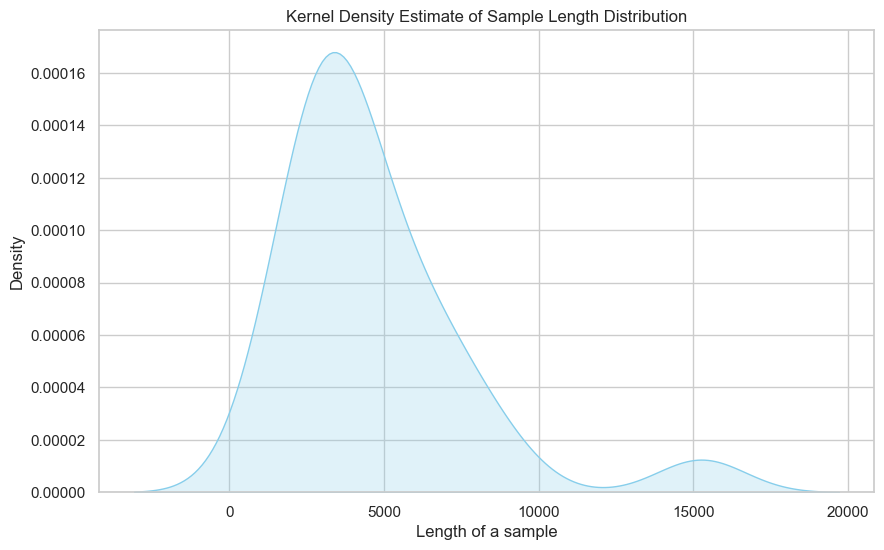

In [50]:
plot_sample_length_distribution(df['article_cleaned'].tolist())

It's important to note that the values on the y-axis are not direct probabilities but rather a measure of how densely the data is distributed along the x-axis.Higher values on the y-axis indicate areas where the data is more densely distributed, and lower values indicate less dense regions.
Based on the above distribution, we can infer that one or two articles were very long while the remaining articles were mostly of the range of similar lengths.

In [51]:
result = df.groupby('region')['article_cleaned'].apply(lambda x: np.mean(x.apply(lambda y: len(y.split()))))
print("\nNumber of words per sample for each region:")
print(result)


Number of words per sample for each region:
region
east-coast    827.333333
mid-west      420.333333
west-coast    617.533333
Name: article_cleaned, dtype: float64


<Axes: ylabel='Density'>

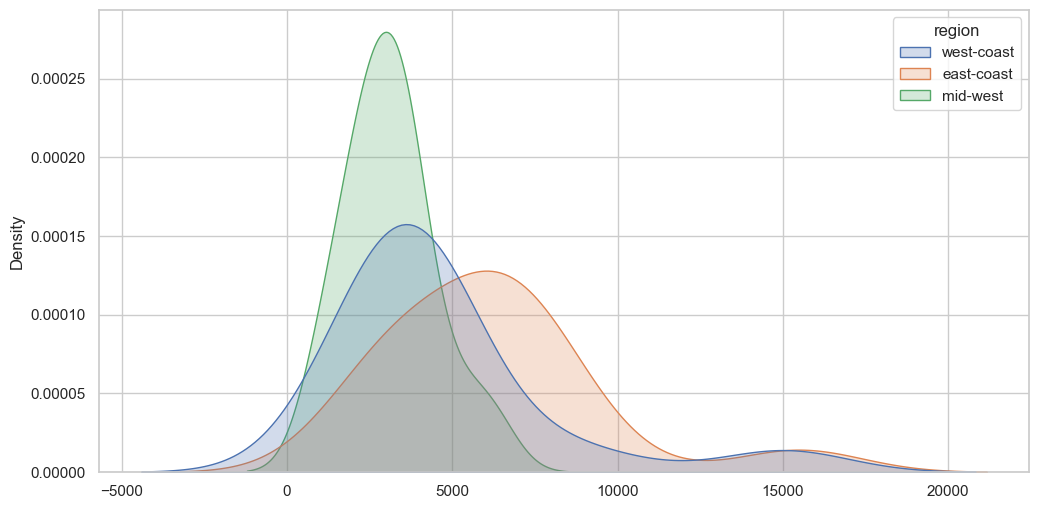

In [52]:
sns.set(style="whitegrid")
# Create a KDE plot with different visualizations based on region
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x=[len(s) for s in df['article_cleaned']], hue=df['region'], fill=True, common_norm=False)

Based on the distribution plot above, we can infer that the articles in mid west were mostly in the range of same length while the articles from east coast were of varied lengths.

In [58]:
# finding the frequently used words in articles for each year
from collections import Counter

my_dict = {}

for year in df['year'].unique():
    text_year = ' '.join(df[df['year'] == year]['article_cleaned'])
    all_words = text_year.lower().split()

    word_counts = Counter(all_words)
    sorted_items = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))

    top_keys = list(sorted_items.keys())[:10]
    my_dict[year] = top_keys

print("The top 10 words frequently used in the articles published each year include the following:")
my_dict

The top 10 words frequently used in the articles published each year include the following:


{2022: ['electric',
  'cars',
  'vehicles',
  'said',
  'ev',
  'would',
  'evs',
  'credit',
  'tax',
  'battery'],
 2023: ['electric',
  'vehicles',
  'new',
  'said',
  'energy',
  'cars',
  'evs',
  'ev',
  'vehicle',
  'car'],
 2021: ['electric',
  'cars',
  'said',
  'emissions',
  'vehicle',
  'vehicles',
  'climate',
  'would',
  'new',
  'cost'],
 2019: ['vehicles',
  'electric',
  'city',
  'said',
  'san',
  'francisco',
  'tax',
  'charging',
  'state',
  'cars'],
 2020: ['charging',
  'transportation',
  'install',
  'level',
  'stations',
  'county',
  '2',
  'public',
  'projects',
  'ev'],
 2015: ['tax',
  'electric',
  'exemption',
  'said',
  'sales',
  'would',
  'carlyle',
  'state',
  'vehicles',
  'magendanz'],
 2018: ['state',
  'evs',
  'law',
  'fleet',
  'vehicles',
  'fleets',
  'washington',
  'public',
  'local',
  'electric'],
 2017: ['electric',
  'cities',
  'vehicles',
  'emissions',
  'cars',
  'houston',
  'leaf',
  'charging',
  'stations',
  'states

### Keyword Extraction

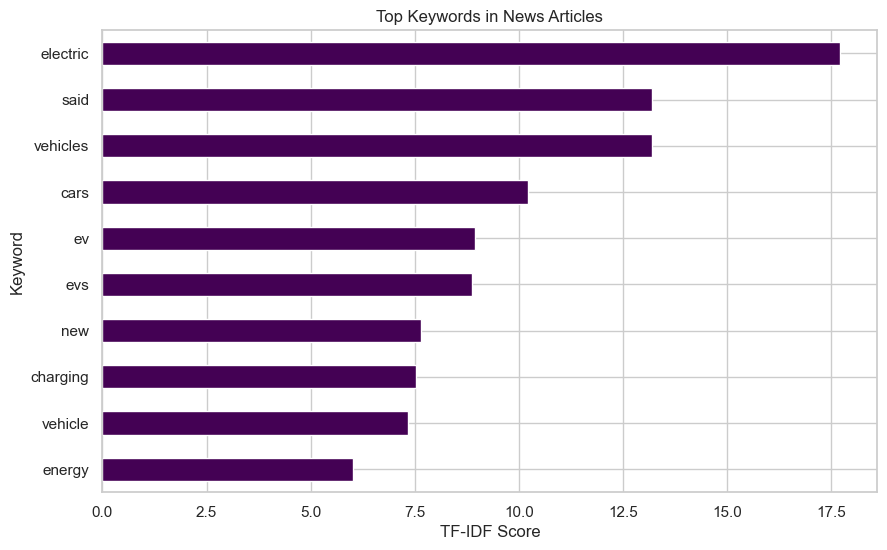

In [137]:
"""
This code uses TF-IDF to extract and visualize the top keywords from the news articles.
"""

from sklearn.feature_extraction.text import TfidfVectorizer
corpus = df['article_cleaned']

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=10, stop_words='english')

# Fit and transform the corpus
tfidf_matrix = vectorizer.fit_transform(corpus)

# Get feature names (keywords)
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame to display the top keywords
keywords_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Plot the top keywords
plt.figure(figsize=(10, 6))
keywords_df.sum().sort_values().plot(kind='barh', colormap='viridis')
plt.title('Top Keywords in News Articles')
plt.xlabel('TF-IDF Score')
plt.ylabel('Keyword')
plt.show()

In [62]:
#Top 5 Words in News Articles by Year with Count

# Create an empty DataFrame to store the results
ndf = pd.DataFrame(columns=['Year', 'Top_Word', 'Count'])

for year in df['year'].unique():
    text_year = ' '.join(df[df['year'] == year]['article_cleaned'])
    all_words = text_year.split()
    Freq_word = {}
    for w in all_words:
        w1 = w.lower()
        if w1 in Freq_word:
            Freq_word[w1] += 1
        else:
            Freq_word[w1] = 1
    sorted_items = dict(sorted(Freq_word.items(), key=lambda item: item[1], reverse=True))
    top_keys = list(sorted_items.keys())[:5]

    # Append results to the new DataFrame
    year_df = pd.DataFrame({'Year': [year] * 5, 'Top_Word': top_keys, 'Count': list(sorted_items.values())[:5]})
    ndf = pd.concat([ndf, year_df], ignore_index=True)

# Sort the DataFrame to control the order in the visualization
ndf = ndf.sort_values(by=['Year', 'Count'], ascending=[True, False])

# bar plot using plotly express
fig = px.bar(ndf, x='Top_Word', y='Count', color='Year',
             title='Top 5 Words in News Articles by Year with Count',
             labels={'Top_Word': 'Top Word', 'Count': 'Count', 'Year': 'Year'},
             height=600)

# Adjust layout for better readability
fig.update_layout(
    xaxis_title='Top Words',
    yaxis_title='Count',
    legend_title_text='Year',
    margin=dict(l=20, r=20, t=40, b=40),
)
fig.show()

Based on the visualisation above, we can infer that the electric cars have progressed in a systematic way any product is supposed to progress. Satrting with financial considerations in 2015 to state and law consideration in 2018. From charging station considerations in 2020 to just the discussion about electric vehicles and new possibilities in 2022-23.



In [63]:
# code to analyze the frequency of three consecutive words (trigrams) in the text corpus.
vectorizer = CountVectorizer(ngram_range=(3, 3))
ngrams = vectorizer.fit_transform(df['article_cleaned'])

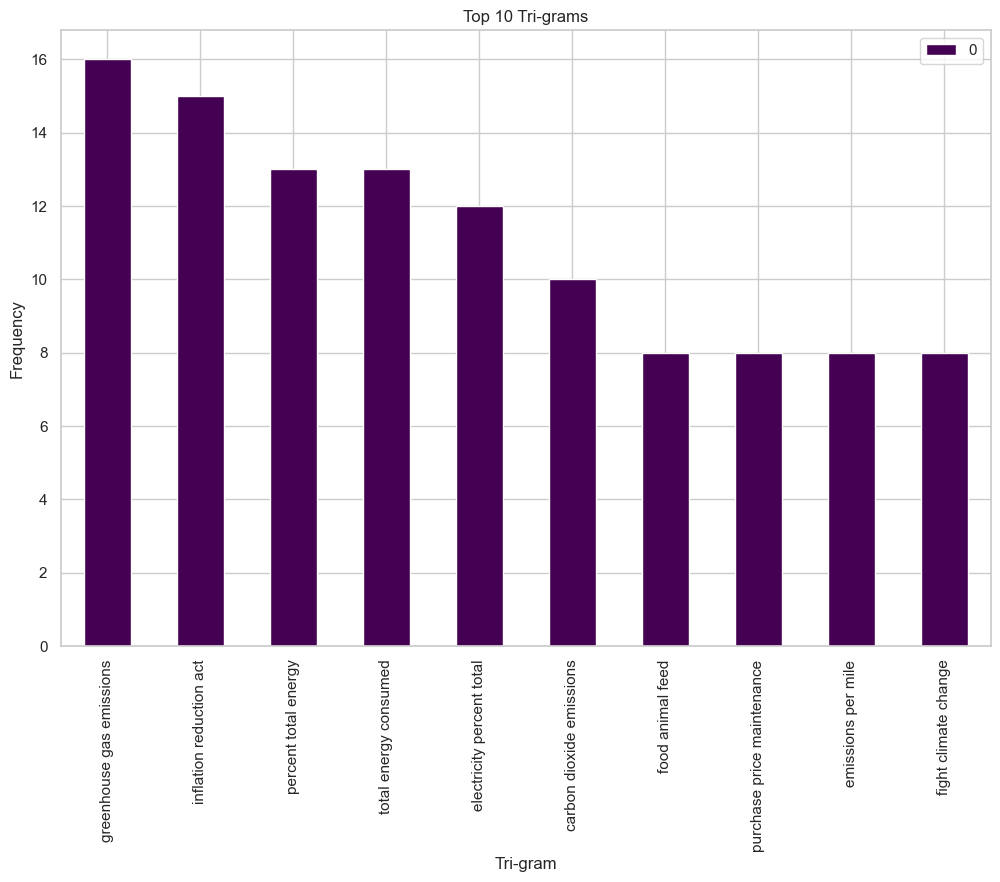

In [66]:
ngrams_freq = pd.DataFrame(ngrams.sum(axis=0), columns=vectorizer.get_feature_names_out()).T.sort_values(0, ascending=False)
ngrams_freq.head(10).plot(kind='bar', figsize=(12, 8), colormap='viridis')
plt.title('Top 10 Tri-grams')
plt.xlabel('Tri-gram')
plt.ylabel('Frequency')
plt.show()

Based on the data above, mostly the article focussed on climate change considerations and energy consumption statistics, which is the most reasonable way to respresent electric vehicles. The highest written topic being greenhouse gas emissions, which shows the media was mostly trying to foster the production of electrical vehicles.

In [67]:
# Load spaCy model for NER
nlp = spacy.load("en_core_web_sm")

In [68]:
# Create a new column 'entities' to store the extracted entities
df['entities'] = df['article_cleaned'].apply(lambda text: [(ent.text, ent.label_) for ent in nlp(text).ents])

This column is to store information about named entities detected in the 'article_cleaned' column of the DataFrame. it contains identified entities and their corresponding labels (e.g., person, organization, location).

In [69]:
df.head()

,title,article,news_source,region,article_cleaned,converted_date,year,entities
article_no,,,,,,,,
0,Commentary: Driving an EV does not make you p...,['When I started driving an electric vehicle i...,latimes,west-coast,started driving electric vehicle 2018 became p...,09-17-2022,2022,"[(2018, DATE), (100, CARDINAL), (2035, DATE), ..."
1,Op-Ed: Think bigger. Switching to electric ca...,['It might feel like the easy solution — just ...,latimes,west-coast,might feel like easy solution replace gasguzzl...,09-15-2022,2022,"[(california, GPE), (last month 2035, DATE), (..."
2,Editorial: EPA wants to speed up EV switch. G...,['The Biden administration just proposed hitti...,latimes,west-coast,biden administration proposed hitting accelera...,04-12-2023,2023,"[(biden administration, ORG), (wednesday, DATE..."
3,"California’s electric car revolution, designe...",['The precious cargo on the ship docked in San...,latimes,west-coast,precious cargo ship docked san diego bay strik...,07-21-2021,2021,"[(san diego bay, LOC), (thousands miles, QUANT..."
4,Electric cars now make up a fifth of Californ...,['One out of every 5 cars sold in California i...,latimes,west-coast,one every 5 cars sold california powered batte...,11-01-2023,2023,"[(one, CARDINAL), (5, CARDINAL), (california, ..."


In [70]:
df['entities'][0]

[('2018', 'DATE'),
 ('100', 'CARDINAL'),
 ('2035', 'DATE'),
 ('2018', 'DATE'),
 ('la el', 'GPE'),
 ('months', 'DATE'),
 ('five hours day', 'TIME'),
 ('nissan', 'ORG'),
 ('60mile', 'CARDINAL'),
 ('daily', 'DATE'),
 ('200', 'CARDINAL'),
 ('los angeles', 'GPE'),
 ('294', 'CARDINAL'),
 ('2021', 'CARDINAL'),
 ('american', 'NORP'),
 ('one', 'CARDINAL'),
 ('los angeles', 'GPE'),
 ('nearly 10000', 'CARDINAL'),
 ('california', 'GPE')]

In [72]:
# this code extracts information about named entities from the DataFrame (df) and organizing it into a new DataFrame (entity_df)

# Create an empty list to store DataFrames
dfs = []

# Iterate through each row in the original DataFrame
for idx, row in df.iterrows():
    year = row['year']
    entities = row['entities']

    # Create a DataFrame for the current row's entities
    entity_df_row = pd.DataFrame({'year': [year]*len(entities),
                                  'entity': [entity[0] for entity in entities],
                                  'label': [entity[1] for entity in entities]})

    # Append the DataFrame to the list
    dfs.append(entity_df_row)

# Concatenate all DataFrames in the list into a single DataFrame
entity_df = pd.concat(dfs, ignore_index=True)

# Reset index for clarity
entity_df.reset_index(drop=True, inplace=True)

In [73]:
entity_df.head(10)

,year,entity,label
0,2022,2018,DATE
1,2022,100,CARDINAL
2,2022,2035,DATE
3,2022,2018,DATE
4,2022,la el,GPE
5,2022,months,DATE
6,2022,five hours day,TIME
7,2022,nissan,ORG
8,2022,60mile,CARDINAL
9,2022,daily,DATE


In [74]:
entity_df['year'].unique()

array([2022, 2023, 2021, 2019, 2020, 2015, 2018, 2017], dtype=int64)

In [15]:
entity_df['label'].unique()

array(['DATE', 'CARDINAL', 'GPE', 'TIME', 'ORG', 'NORP', 'QUANTITY',
       'LOC', 'ORDINAL', 'PERSON', 'MONEY', 'PRODUCT', 'PERCENT', 'FAC',
       'WORK_OF_ART', 'EVENT', 'LANGUAGE'], dtype=object)

In [79]:
# Extract 'year' and 'ORG' columns
org_df = entity_df[['year', 'entity','label']]

# Filter rows with 'ORG' label
org_df = org_df[org_df['label'] == 'ORG']

# Flatten the list of ORG entities
org_df = org_df.explode('entity')

In [80]:
org_df.head()

,year,entity,label
7,2022,nissan,ORG
46,2023,biden administration,ORG
50,2023,epa,ORG
56,2023,epa,ORG
62,2023,epa,ORG


In [81]:
# Count occurrences of each ORG in each year
org_counts_by_year = org_df.groupby(['year', 'entity']).size().reset_index(name='Count')

# Display the top 5 most occurred ORG in each year
top_orgs_by_year = org_counts_by_year.groupby('year').apply(lambda x: x.nlargest(5, 'Count')).reset_index(drop=True)
top_orgs_by_year.rename(columns={'entity': 'ORG'}, inplace=True)
top_orgs_by_year.head()

,year,ORG,Count
0,2015,nissan,3
1,2015,hill,1
2,2015,mann,1
3,2015,ritzville house,1
4,2015,senate,1


In [85]:
#Top 5 Most Occurred ORG in Each Year
fig = px.bar(top_orgs_by_year, x='Count', y='ORG', color='year',
             labels={'Count': 'Occurrences'},
             title='Top 5 Most Occurred ORG in Each Year',
             category_orders={"year": sorted(top_orgs_by_year['year'], reverse=True)})
fig.update_layout(
    width=1000,  
    height=700, 
)
fig.show()

From the above visualization we can infer that, along the years the organizations ford and nissan were under discussion on social media throughout.During the later years companies like hyundai and kia came into discussion. In the initial years mostly some resources, batteries and energy industries were reported in media.

In [86]:
# Create a geocoder
geolocator = Nominatim(user_agent="location_plotter")

def get_coordinates(location):
    try:
        location_info = geolocator.geocode(location)
        return (location_info.latitude, location_info.longitude)
    except:
        return None

# Filter out NaN values from the list
locations = [loc for loc in entity_df[entity_df['label']=='GPE']['entity'] if pd.notnull(loc)]

# Get coordinates for each location
coordinates = [get_coordinates(location) for location in locations]

# Filter out None values from the coordinates
coordinates = [coord for coord in coordinates if coord is not None]

# Create a folium map centered around the first location
map_center = coordinates[0]
map_obj = folium.Map(location=map_center, zoom_start=4)

# Add markers for each location
for coord, location in zip(coordinates, locations):
    folium.Marker(coord, popup=location).add_to(map_obj)

# Display the map directly in the Jupyter Notebook
display(map_obj)


The above data shows all the places that were mentioned in the news articles. These were the places under discussion when it comes to electric vehicles. It could be either the evs are already there or under the plan of introducing them, in the discussions of the social media in US.

In [87]:
entity_df[entity_df['label']=='PERSON']['entity'].value_counts().head(10)

joe bidens         7
evs                6
mustang mache      4
chris              4
mustang mach       3
matthew metz       2
jessika trancik    2
tom krisher        2
melvin carter      2
granholm           2
Name: entity, dtype: int64

The above data represents the people that were most mentioned in the articles during the years. This can inform how the electric vehicles progressed over years as the president was mentioned in the articles the most times. This means the electric vehicles came under the discussion of country's topics very often.

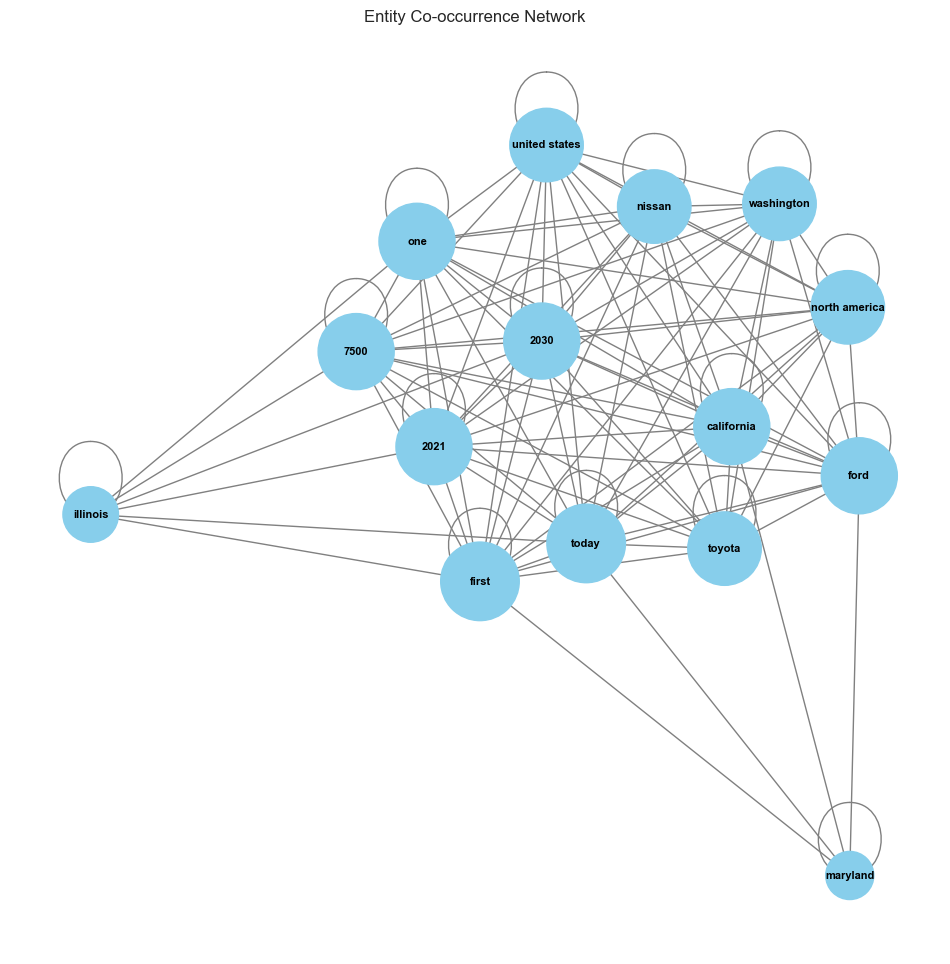

In [152]:
# Create a graph
G = nx.Graph()

# Count entity occurrences
entity_counts = {}
for entities_list in df['entities']:
    for entity, _ in entities_list:
        entity_counts[entity] = entity_counts.get(entity, 0) + 1

# Choose top 15 entities based on frequency
top_entities = [entity for entity, count in sorted(entity_counts.items(), key=lambda x: x[1], reverse=True)[:15]]

# Iterate through each row in the DataFrame
for entities_list in df['entities']:
    # Filter entities
    filtered_entities = [(entity, label) for entity, label in entities_list if entity in top_entities]

    # Add edges between filtered entities in the same article
    for i in range(len(filtered_entities)):
        for j in range(i + 1, len(filtered_entities)):
            # Add nodes and edge to the graph
            node1, label1 = filtered_entities[i]
            node2, label2 = filtered_entities[j]
            G.add_node(node1, label=label1)
            G.add_node(node2, label=label2)
            G.add_edge(node1, node2)

# Calculate node degrees
node_degrees = dict(G.degree())

# Visualize the co-occurrence network with customization options
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # You can try different layout algorithms

# Explicitly create an axis
ax = plt.gca()

# Draw the graph with node size based on degree
node_size = [200 * node_degrees[node] for node in G.nodes]
nx.draw(G, pos, with_labels=True, font_size=8, font_color='black', font_weight='bold', 
        node_size=node_size, node_color='skyblue', edge_color='gray', linewidths=1, ax=ax)

plt.title('Entity Co-occurrence Network')
plt.show()

The network provides insights into the interconnectedness of entities in news articles. For instance, it reveals common themes, recurring topics, or relationships between key entities.

Nodes represent entities, and their size is proportional to their degree (the number of connections)

Edges connect entities that frequently co-occur within the same articles. Thicker edges indicate stronger co-occurrence relationships.

The top 15 entities, determined by their overall frequency, are prominently featured in the network. These entities play a central role in connecting with other entities.

### Cross-Region Comparison

In [156]:
"""
 Creates a stacked bar chart where each bar represents a region, 
 and the segments within the bar represent the counts of different entities. 
 It provides a visual comparison of the distribution of top entities across regions.
"""
# distribution of the top entities in each region

# Create a DataFrame to store entity counts for each region
region_entity_counts = pd.DataFrame(index=top_entities, columns=df['region'].unique())

# Fill the DataFrame with entity counts
for region in df['region'].unique():
    region_df = df[df['region'] == region]
    entity_counts = {}
    for entities_list in region_df['entities']:
        for entity, _ in entities_list:
            entity_counts[entity] = entity_counts.get(entity, 0) + 1
    region_entity_counts[region] = region_entity_counts.index.map(entity_counts)

# Transpose the DataFrame for better visualization
region_entity_counts = region_entity_counts.T

# Convert the DataFrame to long format for Plotly
region_entity_counts_long = region_entity_counts.reset_index().melt(id_vars='index', var_name='Entity', value_name='Entity Count')

# Create an interactive stacked bar chart with hover information
fig = px.bar(region_entity_counts_long, x='index', y='Entity Count', color='Entity', barmode='stack',
             labels={'index': 'Region', 'Entity Count': 'Entity Count'},
             title='Top Entities Distribution Across Regions',
             hover_data={'Entity': True, 'Entity Count': True})

# Show the interactive plot
fig.show()

From the above vizualization:
California is more frequently mentioned on the West Coast, which is expected given its location.
Ford is prominently mentioned on the East Coast.
The mentions of "North America" are more concentrated on the East Coast.

### Indepth analysis of above Visualization

## Electric Vehicles (EVs)
- **West Coast:** High mentions (e.g., "electric," "cars," "EV") indicate a strong emphasis on electric vehicles, aligning with the region's known interest in sustainable technology.
- **East Coast:** Consistent high mentions suggest a parallel interest in electric vehicles on the East Coast, reflecting a shared focus with the West Coast.
- **Mid-West:** While there are mentions, the frequency is comparatively lower, indicating a potentially lower emphasis or coverage of electric vehicles in this region.

## Charging Infrastructure
- **West Coast:** Prominent mentions of "charging" and "stations" suggest a focus on the infrastructure supporting electric vehicles.
- **East Coast:** Similar to the West Coast, there is notable coverage of charging infrastructure, indicating shared interests.
- **Mid-West:** The mentions of charging infrastructure are present but less frequent, suggesting potential differences in emphasis or coverage priorities.

## Climate and Emissions
- **West Coast:** The mention of "climate" suggests a focus on the environmental aspects of electric vehicles, aligning with the region's emphasis on sustainability.
- **East Coast:** The presence of "climate" indicates a shared interest in the environmental impact of electric vehicles.
- **Mid-West:** While there are mentions, the frequency is relatively lower, suggesting variations in coverage priorities.

## Maryland
- **West Coast:** The absence of mentions indicates limited coverage or interest in Maryland related to electric vehicles.
- **East Coast:** Maryland is prominently mentioned, suggesting a specific focus on developments or topics related to electric vehicles in this state.
- **Mid-West:** Maryland is not mentioned, indicating a regional difference in coverage.

## Washington
- **West Coast:** Washington is mentioned, indicating interest in electric vehicles in the state.
- **East Coast:** Washington is also mentioned, potentially reflecting national-level coverage or shared interests.
- **Mid-West:** Washington is mentioned but less frequently, suggesting variations in regional priorities.

## Illinois
- **West Coast:** The absence of mentions indicates limited coverage or interest in Illinois related to electric vehicles.
- **East Coast:** Illinois is mentioned, suggesting a specific focus on developments or topics related to electric vehicles in this state.
- **Mid-West:** Illinois is prominently mentioned, indicating significant coverage and interest.

## 2030
- **West Coast:** The mentions of "2030" suggest a focus on future developments or targets related to electric vehicles.
- **East Coast:** Similar to the West Coast, the mentions of "2030" indicate shared interests in future milestones.
- **Mid-West:** While there are mentions, the frequency is comparatively lower, suggesting potential differences in emphasis.

This analysis provides insights into the regional variations in coverage and emphasis on specific entities related to electric vehicles.


In [158]:
print(region_entity_counts_long)

         index         Entity  Entity Count
0   west-coast     california          42.0
1   east-coast     california          13.0
2     mid-west     california           1.0
3   west-coast            one          18.0
4   east-coast            one          18.0
5     mid-west            one          10.0
6   west-coast           ford           3.0
7   east-coast           ford          26.0
8     mid-west           ford           5.0
9   west-coast  united states           4.0
10  east-coast  united states          24.0
11    mid-west  united states           1.0
12  west-coast         nissan           5.0
13  east-coast         nissan          14.0
14    mid-west         nissan           7.0
15  west-coast           2021           3.0
16  east-coast           2021          17.0
17    mid-west           2021           5.0
18  west-coast          first           6.0
19  east-coast          first          12.0
20    mid-west          first           4.0
21  west-coast  north america   

### Topic Modeling

In [115]:
#This code performs topic modeling on text data using Latent Dirichlet Allocation (LDA) for different regions.
# 'article_cleaned' columns already contains the text that is lemmatized and cleaned.
region_topics = {}

for region, region_df in df.groupby('region'):
    print(region)
    # 'article_cleaned' column already contains preprocessed text
    tokens = [word_tokenize(text) for text in region_df['article_cleaned']]
    
    # Create a dictionary and a corpus for each region
    
    # mapping between words and their integer IDs(each unique word is assigned a unique numerical identifier)
    dictionary = Dictionary(tokens)
    
    # each document is represented as a list of word IDs along with their frequencies
    corpus = [dictionary.doc2bow(token_list) for token_list in tokens]

    # LDA Model set to iterate 15 times over the entire corpus
    lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15, random_state=42)

    # Get topics
    topics = lda_model.show_topics(num_words=5, formatted=False)

    region_topics[region] = topics

east-coast
mid-west
west-coast


In [116]:
print(type(tokens))

<class 'list'>


In [117]:
print(tokens[0])

['started', 'driving', 'electric', 'vehicle', '2018', 'became', 'part', 'problem', 'reasons', 'cited', 'ev', 'critics', 'recent', 'heat', 'wave', 'state', 'asked', 'electric', 'cars', 'charged', 'peak', 'demand', 'prompted', 'howls', 'told', 'think', 'electrification', 'everything', 'home', 'appliances', 'cars', 'leftwing', 'pipe', 'dream', 'especially', 'light', 'californias', 'mandate', 'requiring', '100', 'new', 'vehicle', 'sales', 'zeroemission', '2035', 'part', 'problem', 'worries', 'expressed', 'ad', 'nauseum', 'ev', 'skeptics', 'much', 'merit', 'yes', 'driving', 'distance', 'issue', 'tiny', 'percentage', 'trips', 'yes', 'electricity', 'bill', 'higher', 'additional', 'cost', 'far', 'lower', 'drivers', 'pay', 'gas', 'yes', 'apartment', 'condo', 'dwellers', 'plug', 'night', 'legitimate', 'concerns', 'must', 'rely', 'public', 'charging', 'infrastructure', 'growing', 'yes', 'evs', 'carbon', 'footprint', 'still', 'typically', 'much', 'smaller', 'gas', 'cars', 'evidence', 'compelling',

In [118]:
len(tokens[0])

427

In [119]:
len(df['article_cleaned'][0].split())

427

In [120]:
print(type(corpus))

<class 'list'>


In [121]:
# each tuple contains a word ID and its frequency in the document (document-term matrix)
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 5), (48, 1), (49, 12), (50, 1), (51, 5), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 2), (58, 1), (59, 3), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 2), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 2), (92, 1), (93, 4), (94, 1), (95, 1), (96, 1), (97, 1), (98, 13), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1

In [123]:
# validation
test_id = 3
token_name = dictionary.get(test_id)
print(f"The token name for ID {test_id} is: {token_name}")

The token name for ID 3 is: 2018


In [113]:
print(len(corpus[0]))

312


In [101]:
print(dictionary,type(dictionary))

Dictionary<3467 unique tokens: ['100', '10000', '200', '2018', '2021']...> <class 'gensim.corpora.dictionary.Dictionary'>


In [124]:
#The output of an LDA model:
# For each document: a distribution of topics.
# For each topic: a distribution of words.
region_topics

{'east-coast': [(0,
   [('electric', 0.013918844),
    ('cars', 0.010919914),
    ('emissions', 0.009822415),
    ('ev', 0.00794394),
    ('said', 0.00793889)]),
  (1,
   [('energy', 0.019233901),
    ('heating', 0.014526396),
    ('electric', 0.013474302),
    ('electricity', 0.011279791),
    ('trucks', 0.009109788)]),
  (2,
   [('electric', 0.010498087),
    ('new', 0.007890885),
    ('vehicles', 0.007880836),
    ('climate', 0.006565541),
    ('said', 0.005603194)]),
  (3,
   [('electric', 0.016992034),
    ('vehicles', 0.014649653),
    ('new', 0.009169191),
    ('cars', 0.0081283795),
    ('said', 0.007349874)]),
  (4,
   [('maryland', 0.011919924),
    ('said', 0.008977782),
    ('year', 0.008594333),
    ('vehicles', 0.0063909767),
    ('electric', 0.0056564566)])],
 'mid-west': [(0,
   [('electric', 0.018183071),
    ('vehicles', 0.014348478),
    ('credit', 0.01016688),
    ('new', 0.008426587),
    ('ev', 0.0073850476)]),
  (1,
   [('houston', 0.0070440886),
    ('energy', 0

for each region, Lists containing tuples, where each tuple represents a topic within that region.
and for each tuple inside the list in each region:

Tuple Format: (topic_number, word_probability_list)
topic_number: An identifier for the topic within that region.
word_probability_list: A list of tuples, where each tuple represents a word and its probability within that topic.

word_probability_list format:
Tuple Format: ('word', probability)
'word': The actual word associated with the topic.
probability: The probability of that word being part of the topic.

Ex: for east_coast: there are multiple topics identified. For Topic 0, the most probable words include 'electric', 'cars', and so on. Similarly, for Topic 1, the most probable words include 'energy', 'heating', and so forth.

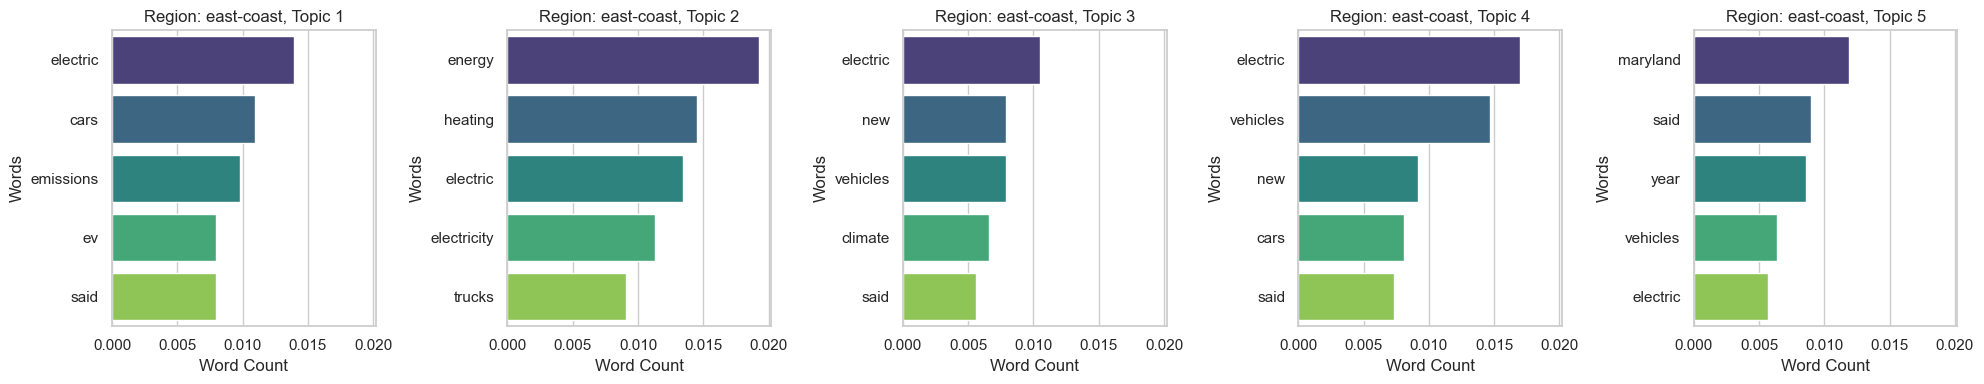

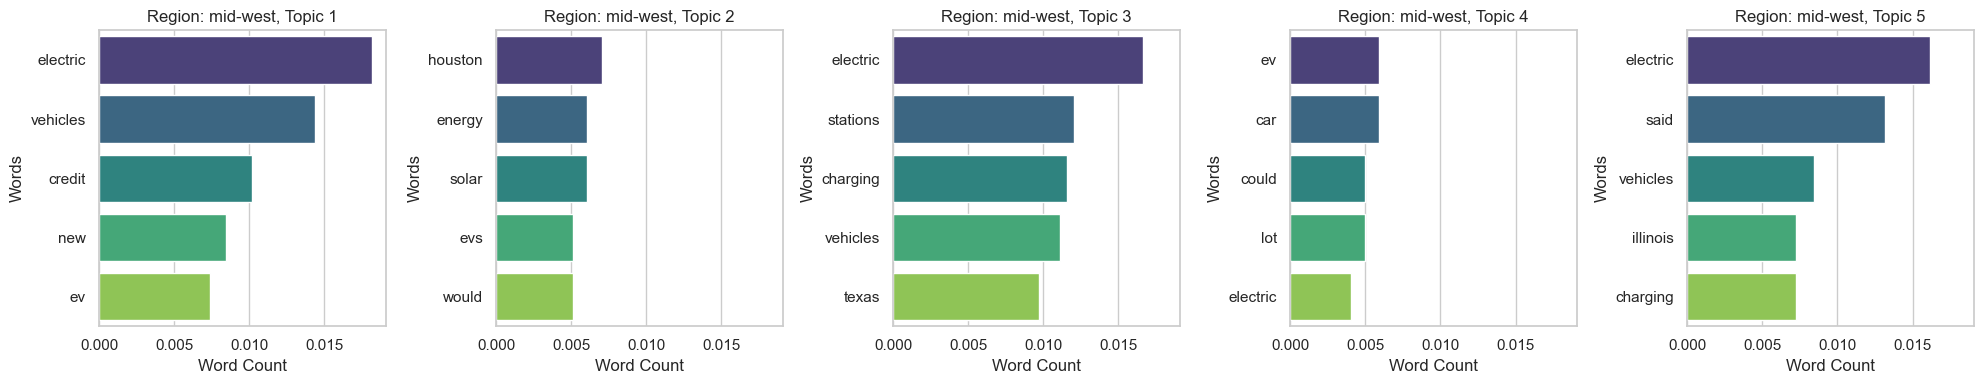

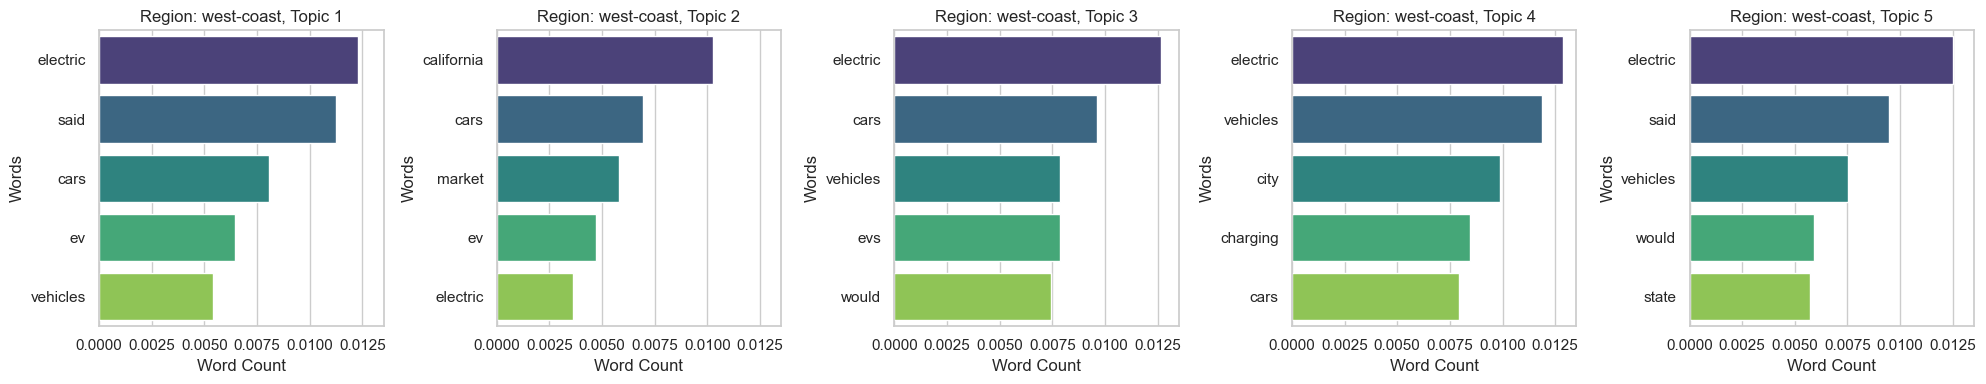

In [125]:
# vizualization of above topic modelling
for region, topics in region_topics.items():
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4), sharex=True)
    axes = axes.flatten()
    for i, (topic, ax) in enumerate(zip(topics, axes)):
        topic_words = [word for word, _ in topic[1]]
        sns.barplot(x=[count for _, count in topic[1]], y=topic_words, ax=ax, palette='viridis')
        ax.set_title(f'Region: {region}, Topic {i + 1}')
        ax.set_xlabel('Word Count')
        ax.set_ylabel('Words')

    plt.tight_layout()
    plt.show()

Based on the data above, regarding 5 topics identified in each region. The topics modelled in each region are mostly on the same line. East coast has topics more related to greenouse emissions, west-coast more related to power consumption and mid-west more related to the places of vehicles and charging stations.

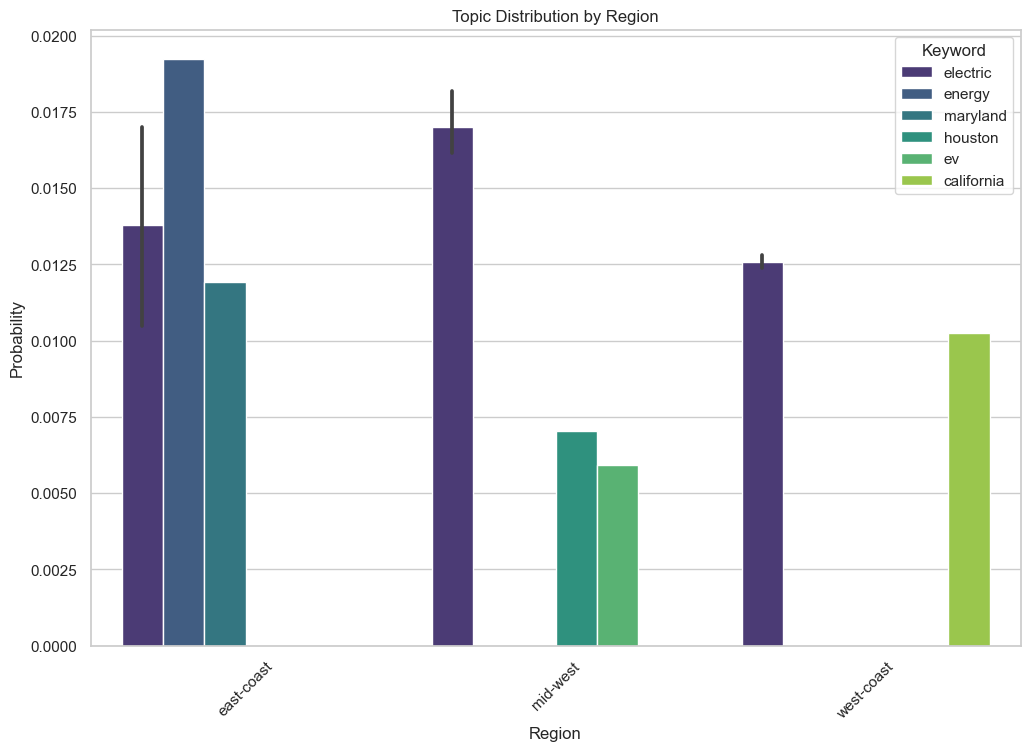

In [133]:
"""
bar plot showing the distribution of topics by region. Each region is represented by a different color, 
and the height of the bars represents the probability of a keyword within a topic.
"""

# Flatten the topics for visualization
flat_topics = [(region, topic, word_prob[0][0], word_prob[0][1]) for region, topics in region_topics.items() for topic, word_prob in topics]

# Create a DataFrame for visualization
topics_df = pd.DataFrame(flat_topics, columns=['Region', 'Topic', 'Keyword', 'Probability'])

# Plot the distribution of topics by region
plt.figure(figsize=(12, 8))
sns.barplot(x='Region', y='Probability', hue='Keyword', data=topics_df, palette='viridis')
plt.title('Topic Distribution by Region')
plt.xlabel('Region')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.show()